In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
#Surprise
from surprise import SVD, KNNBasic, Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise.model_selection import KFold
from surprise import accuracy
# Importar librerías necesarias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import copy
# Librerías de Scikit-learn
from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier


In [4]:
df = pd.read_csv("C:/Users/Joel/Documents/UAB/Tercer/Primer_Semestre/AC - Aprenentatge Computacional/Projecte/ratings_Electronics.csv",
                             names=['userId', 'productId','rating','timestamp'])
print(df.shape[0])

7824482


In [5]:
df_save = df
df = df_save
print(df.head())

           userId   productId  rating   timestamp
0   AKM1MP6P0OYPR  0132793040     5.0  1365811200
1  A2CX7LUOHB2NDG  0321732944     5.0  1341100800
2  A2NWSAGRHCP8N5  0439886341     1.0  1367193600
3  A2WNBOD3WNDNKT  0439886341     3.0  1374451200
4  A1GI0U4ZRJA8WN  0439886341     1.0  1334707200


In [6]:
print("Total Reviews:",df.shape[0])
print("Total Columns:",df.shape[1])

Total Reviews: 7824482
Total Columns: 4


In [7]:
# Estadístiques dels ratings
print("\nEstadístiques dels ratings:")
print("Minimum rating:", df["rating"].min())
print("Maximum rating:", df["rating"].max())


Estadístiques dels ratings:
Minimum rating: 1.0
Maximum rating: 5.0


In [8]:
print("Total number of ratings :",df.rating.nunique())
print("Total number of users   :", df.userId.nunique())
print("Total number of products  :", df.productId.nunique())

Total number of ratings : 5
Total number of users   : 4201696
Total number of products  : 476002


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [10]:
# Check missing value
df.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [11]:
# Check Duplicate data
df[df.duplicated()].any()

userId       False
productId    False
rating       False
timestamp    False
dtype: bool

In [12]:
# rating describe summary 
df.describe()['rating']

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [13]:
print("Unique value of Rating:",df.rating.unique())

Unique value of Rating: [5. 1. 3. 2. 4.]


In [14]:
# Find the minimum and maximum ratings
print('Minimum rating is: %d' %(df.rating.min()))
print('Maximum rating is: %d' %(df.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [15]:
# Average rating of products
ratings = pd.DataFrame(df.groupby('productId')['rating'].mean())
ratings['ratings_count'] = pd.DataFrame(df.groupby('productId')['rating'].count())
ratings['ratings_average'] = pd.DataFrame(df.groupby('productId')['rating'].mean())
ratings.head(10)

,rating,ratings_count,ratings_average
productId,,,
0132793040,5.000000,1,5.000000
0321732944,5.000000,1,5.000000
0439886341,1.666667,3,1.666667
0511189877,4.500000,6,4.500000
0528881469,2.851852,27,2.851852
0558835155,3.000000,1,3.000000
059400232X,5.000000,3,5.000000
0594012015,2.000000,8,2.000000
0594017343,1.000000,1,1.000000


<Axes: >

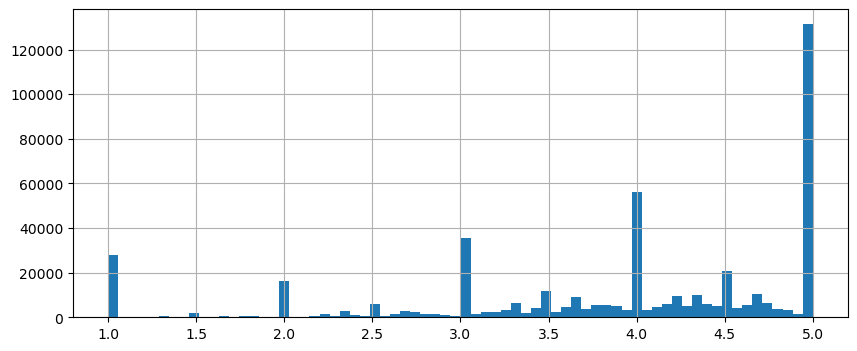

In [16]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

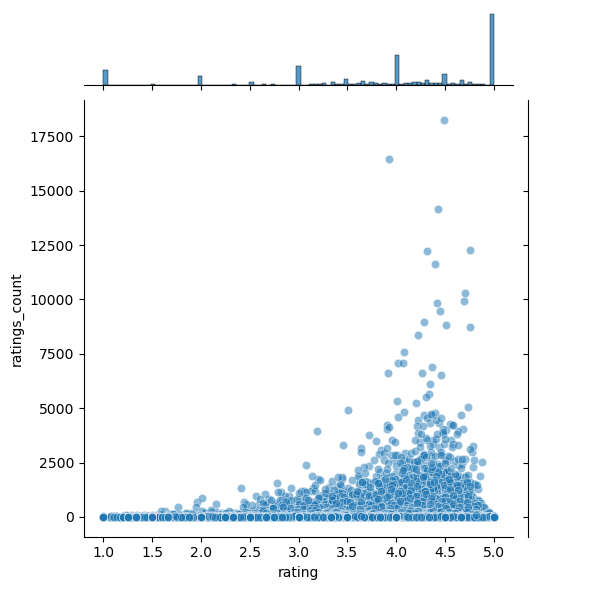

In [17]:
sns.jointplot(x='rating',y='ratings_count',data=ratings,alpha=0.5)

<Axes: xlabel='productId'>

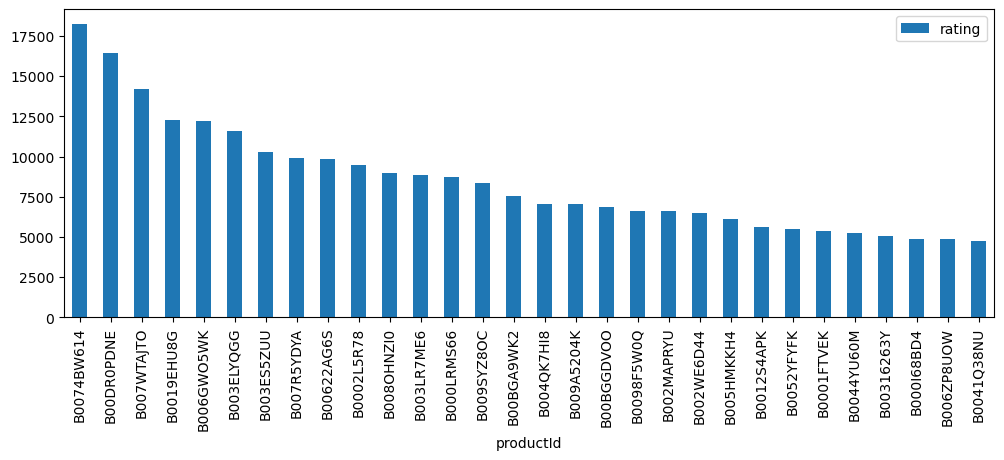

In [18]:
# Most top 30 products
popular_products = pd.DataFrame(df.groupby('productId')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar",figsize=(12, 4))

In [16]:
user_votes = pd.DataFrame(df.groupby('userId')['rating'].count())
users_filter = user_votes[user_votes['rating'] >= 50]

print("Usuarios con más de 50 votos:", users_filter.count())

items_votes = pd.DataFrame(df.groupby('productId')['rating'].count())
items_filter = items_votes[items_votes['rating'] >= 20]

print("Items con más de 5 votos:", items_filter.count())

Usuarios con más de 50 votos: rating    1540
dtype: int64
Items con más de 5 votos: rating    57791
dtype: int64


In [17]:
user_counts = df['userId'].value_counts()
product_counts = df['productId'].value_counts()
filtered_dataset = df[
    (df['userId'].isin(user_counts[user_counts >= 50].index)) &
    (df['productId'].isin(product_counts[product_counts >= 5].index))
]
filtered_dataset.shape

print("Total number of ratings :",filtered_dataset.rating.nunique())
print("Total number of users   :", filtered_dataset.userId.nunique())
print("Total number of products  :", filtered_dataset.productId.nunique())


Total number of ratings : 5
Total number of users   : 1540
Total number of products  : 39939


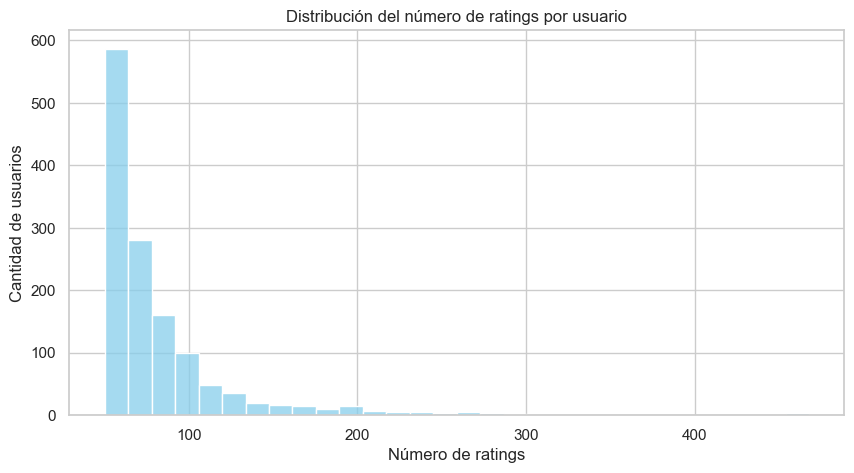

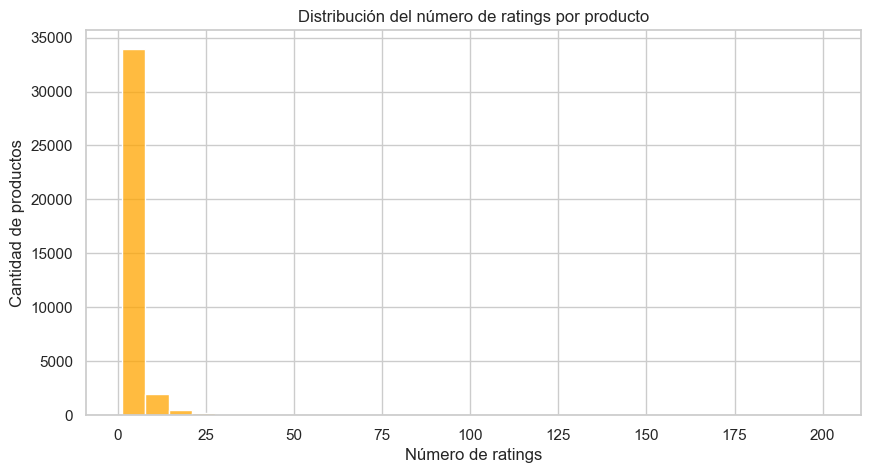

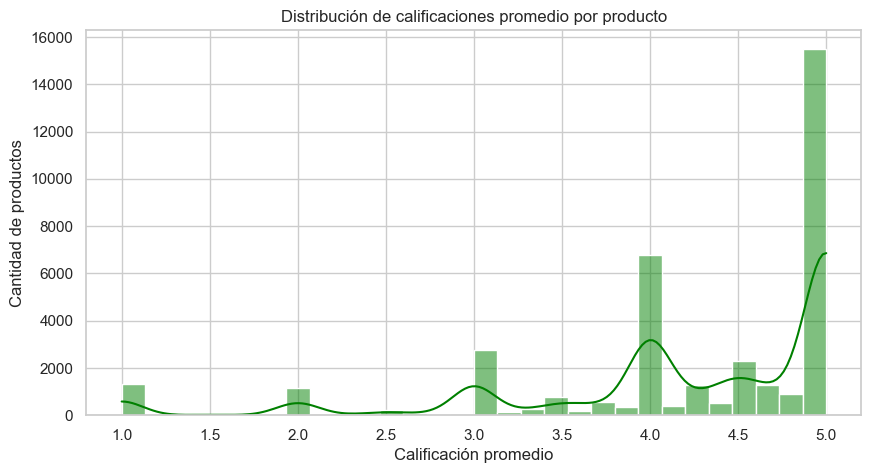

In [21]:
# Estilo general de gráficos
sns.set(style="whitegrid")

# 1. Distribución del número de ratings por usuario
plt.figure(figsize=(10, 5))
sns.histplot(filtered_dataset['userId'].value_counts(), bins=30, kde=False, color='skyblue')
plt.title('Distribución del número de ratings por usuario')
plt.xlabel('Número de ratings')
plt.ylabel('Cantidad de usuarios')
plt.show()

# 2. Distribución del número de ratings por producto
plt.figure(figsize=(10, 5))
sns.histplot(filtered_dataset['productId'].value_counts(), bins=30, kde=False, color='orange')
plt.title('Distribución del número de ratings por producto')
plt.xlabel('Número de ratings')
plt.ylabel('Cantidad de productos')
plt.show()

# 3. Calificaciones promedio por producto
avg_ratings = filtered_dataset.groupby('productId')['rating'].mean()
plt.figure(figsize=(10, 5))
sns.histplot(avg_ratings, bins=30, kde=True, color='green')
plt.title('Distribución de calificaciones promedio por producto')
plt.xlabel('Calificación promedio')
plt.ylabel('Cantidad de productos')
plt.show()


(107263, 4)


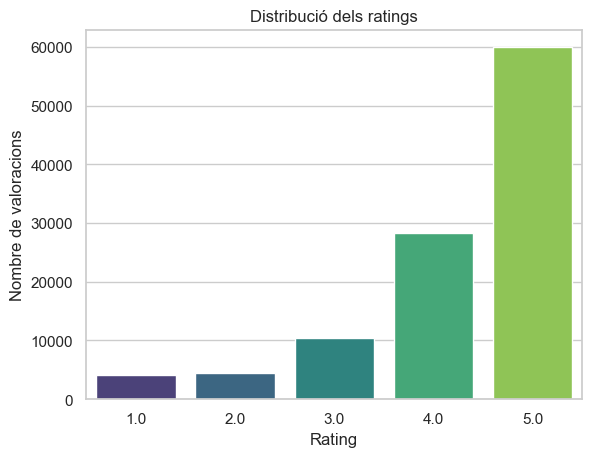

(107263, 4)


In [213]:
print(filtered_dataset.shape)
sns.countplot(data=filtered_dataset, x='rating', palette='viridis')
plt.title("Distribució dels ratings")
plt.xlabel("Rating")
plt.ylabel("Nombre de valoracions")
plt.show()
print(filtered_dataset.shape)

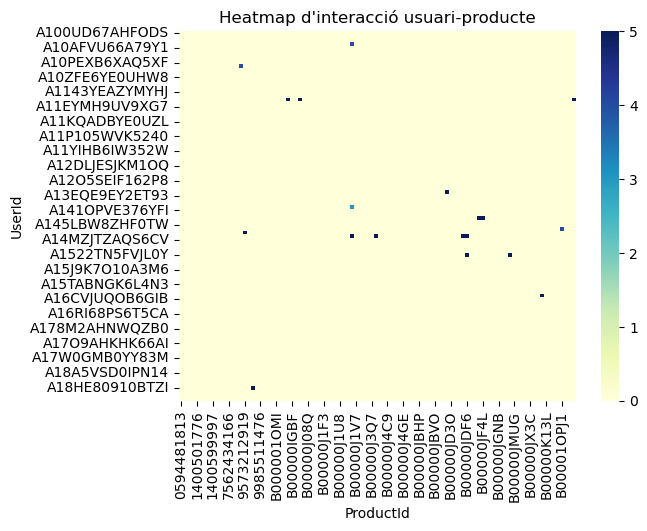

In [24]:
user_product_matrix = filtered_dataset.pivot_table(values='rating', index='userId', columns='productId', fill_value=0)
subset_matrix = user_product_matrix.iloc[:100, :100]  # Subset per visualizació
sns.heatmap(subset_matrix, cmap="YlGnBu", cbar=True)
plt.title("Heatmap d'interacció usuari-producte")
plt.xlabel("ProductId")
plt.ylabel("UserId")
plt.show()


In [18]:
#Matriu correlació
# Convertir 'userId' y 'productId' a valores numéricos (esto puede no tener sentido si solo son identificadores)
matrix_corr_dataset = copy.deepcopy(filtered_dataset)
matrix_corr_dataset['userId_encoded'] = matrix_corr_dataset['userId'].astype('category').cat.codes
matrix_corr_dataset['productId_encoded'] = matrix_corr_dataset['productId'].astype('category').cat.codes

# Ahora calculamos la correlación entre 'userId_encoded', 'productId_encoded' y 'rating'
df_numeric = matrix_corr_dataset[['userId_encoded', 'productId_encoded', 'rating']]

# Calcular la matriz de correlación
correlation_matrix = df_numeric.corr()

# Mostrar la matriz de correlación
print(correlation_matrix)
print(filtered_dataset.shape)

                   userId_encoded  productId_encoded    rating
userId_encoded           1.000000           0.004775  0.005376
productId_encoded        0.004775           1.000000  0.010870
rating                   0.005376           0.010870  1.000000
(117315, 4)


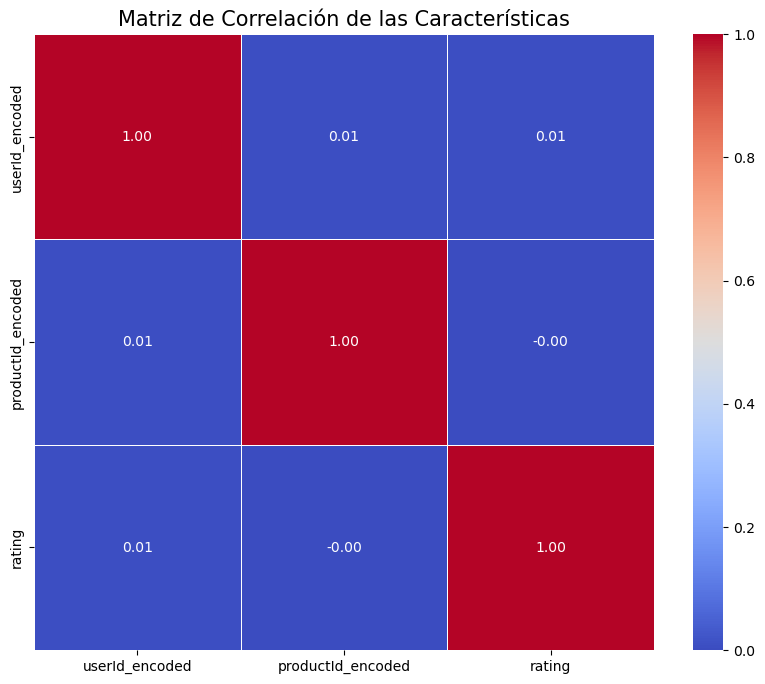

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Título
plt.title('Matriz de Correlación de las Características', fontsize=15)

# Mostrar el gráfico
plt.show()

                 userId   productId  rating   timestamp
118       AT09WGFUM934H  0594481813     3.0  1377907200
177      A32HSNCNPRUMTR  0970407998     1.0  1319673600
178      A17HMM1M7T9PJ1  0970407998     4.0  1281744000
492      A3CLWR1UUZT6TG  0972683275     5.0  1373587200
631      A3TAS1AG6FMBQW  0972683275     5.0  1353456000
...                 ...         ...     ...         ...
7824423  A34BZM6S9L7QI4  B00LGQ6HL8     5.0  1405555200
7824424  A1G650TTTHEAL5  B00LGQ6HL8     5.0  1405382400
7824425  A25C2M3QF9G7OQ  B00LGQ6HL8     5.0  1405555200
7824426   A1E1LEVQ9VQNK  B00LGQ6HL8     5.0  1405641600
7824427  A2NYK9KWFMJV4Y  B00LGQ6HL8     5.0  1405209600

[107263 rows x 4 columns]
userId
ADLVFFE4VBT8      468
A5JLAU2ARJ0BO     463
A3OXHLG6DIBRW8    456
A6FIAB28IS79      412
A680RUE1FDO8B     381
                 ... 
A1ZPUEHF4AES86     50
AR1T36GLLAFFX      50
AW6FQE5QRF2LM      50
A1FOSIV4TWZFR7     50
AN0JK8OQLUC55      50
Name: count, Length: 1320, dtype: int64


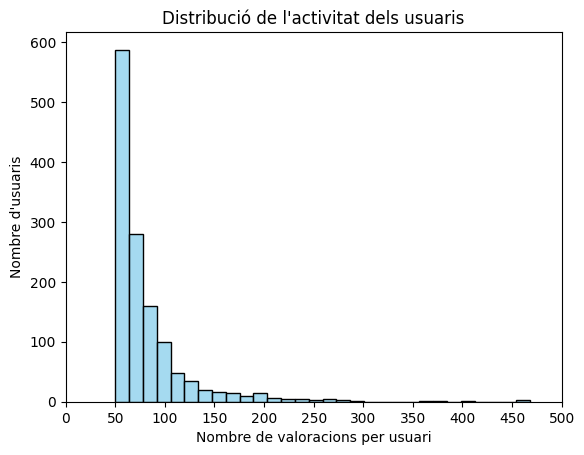

In [29]:
filtered_counts = filtered_dataset['userId'].value_counts()
filtered_counts = filtered_counts[filtered_counts >= 50]
filtered_counts
# Obtener los IDs de usuarios que cumplen la condición
user_ids_of_interest = filtered_counts.index

# Filtrar el DataFrame original
filtered_dataset = filtered_dataset[filtered_dataset['userId'].isin(user_ids_of_interest)]
print(filtered_dataset)
print(filtered_dataset['userId'].value_counts())
user_activity = filtered_dataset.groupby('userId')['rating'].count()
sns.histplot(user_activity, kde=False, bins=30, color='skyblue')
plt.title("Distribució de l'activitat dels usuaris")
plt.xlabel("Nombre de valoracions per usuari")
plt.ylabel("Nombre d'usuaris")
plt.xticks(range(0, user_activity.max() + 50, 50))
plt.show()

In [30]:
# Define el rango de las valoraciones del dataset
reader = Reader(rating_scale=(1, 5))

# Convierte el dataset filtrado en formato Surprise
data = Dataset.load_from_df(filtered_dataset[['userId', 'productId', 'rating']], reader)

# Convierte el dataset en un objeto "DatasetAutoFolds" que puede dividirse
full_trainset = data.build_full_trainset()
trainset, testset = train_test_split(data, test_size=0.2)
#trainset = data.build_full_trainset()

SVD

In [31]:
svd = SVD()
svd.fit(trainset)
pred = svd.test(testset)

User-user

In [32]:
#User-User
sim_options_cosinus = {'name': 'cosine', 'user_based': True} #Distancia cosinus
sim_options_pearson = {'name': 'pearson', 'user_based': True} #Distancia pearson

#Item-Item
sim_options_cosinus_items = {'name': 'cosine', 'user_based': False} #Distancia cosinus
sim_options_pearson_items = {'name': 'pearson', 'user_based': False} #Distancia pearson 

In [33]:
#Model cosinus User-User
model_cosinus = KNNBasic(sim_options=sim_options_cosinus)
model_cosinus.fit(trainset)
predictions_cosinus_user = model_cosinus.test(testset)
#Model cosinus Item-Item
model_cosinus_item = KNNBasic(sim_options=sim_options_cosinus_items)
model_cosinus_item.fit(trainset)
predictions_cosinus_user_item = model_cosinus_item.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
k_values = list(range(1, 25))  # Valores de K de 1 a 50
rmse_values = []
mae_values = []

# Probar diferentes valores de K
sim_options = {'name': 'cosine', 'user_based': False}
for k in k_values:
    # Configuración del modelo KNN con el valor de K actual
    model = KNNBasic(k=k, sim_options=sim_options)
    
    # Ajustar el modelo y hacer predicciones
    model.fit(trainset)
    predictions = model.test(testset)
    
    # Calcular RMSE y MAE
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)
    
    # Guardar los resultados
    rmse_values.append(rmse)
    mae_values.append(mae)

# Graficar RMSE y MAE
plt.figure(figsize=(14, 6))

# RMSE
plt.subplot(1, 2, 1)
plt.plot(k_values, rmse_values, label='RMSE', color='blue', marker='o')
plt.title('Item-Item dist cosinus: Evolución de RMSE con K')
plt.xlabel('K (Número de Vecinos)')
plt.ylabel('RMSE')
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(k_values, mae_values, label='MAE', color='green', marker='o')
plt.title('Item-Item dist cosinus: Evolución de MAE con K')
plt.xlabel('K (Número de Vecinos)')
plt.ylabel('MAE')
plt.grid(True)

plt.tight_layout()
plt.show()

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2399
MAE:  0.8417
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1455
MAE:  0.8099
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1183
MAE:  0.7979


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1143
MAE:  0.8328
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0895
MAE:  0.8244
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0839
MAE:  0.8216
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0823
MAE:  0.8204
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0816
MAE:  0.8200
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0809
MAE:  0.8196
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0806
MAE:  0.8193
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0804
MAE:  0.8191
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0803
MAE:  0.8190
Computing the pearson similarity matrix...
Done computing similarity matr

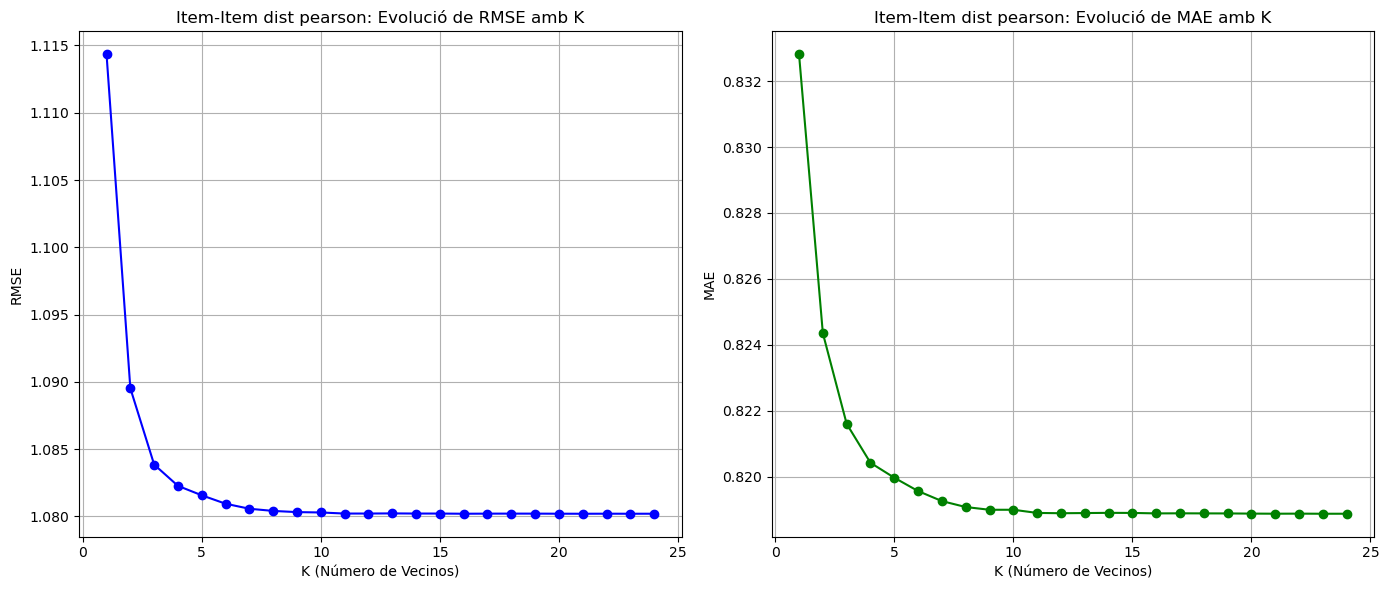

In [95]:
k_values = list(range(1, 25))  # Valores de K de 1 a 50
rmse_values = []
mae_values = []

# Probar diferentes valores de K
for k in k_values:
    # Configuración del modelo KNN con el valor de K actual
    sim_options = {'name': 'pearson', 'user_based': False}
    model = KNNBasic(k=k, sim_options=sim_options)
    
    # Ajustar el modelo y hacer predicciones
    model.fit(trainset)
    predictions = model.test(testset)
    
    # Calcular RMSE y MAE
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)
    
    # Guardar los resultados
    rmse_values.append(rmse)
    mae_values.append(mae)

# Graficar RMSE y MAE
plt.figure(figsize=(14, 6))

# RMSE
plt.subplot(1, 2, 1)
plt.plot(k_values, rmse_values, label='RMSE', color='blue', marker='o')
plt.title('Item-Item dist pearson: Evolució de RMSE amb K')
plt.xlabel('K (Número de Vecinos)')
plt.ylabel('RMSE')
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(k_values, mae_values, label='MAE', color='green', marker='o')
plt.title('Item-Item dist pearson: Evolució de MAE amb K')
plt.xlabel('K (Número de Vecinos)')
plt.ylabel('MAE')
plt.grid(True)

plt.tight_layout()
plt.show()

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2506
MAE:  0.8408
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1614
MAE:  0.8122
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1353
MAE:  0.7990
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1239
MAE:  0.7924
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1188
MAE:  0.7906
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1150
MAE:  0.7884
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1126
MAE:  0.7869
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1109
MAE:  0.7853
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1097
MAE:  0.7846
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 

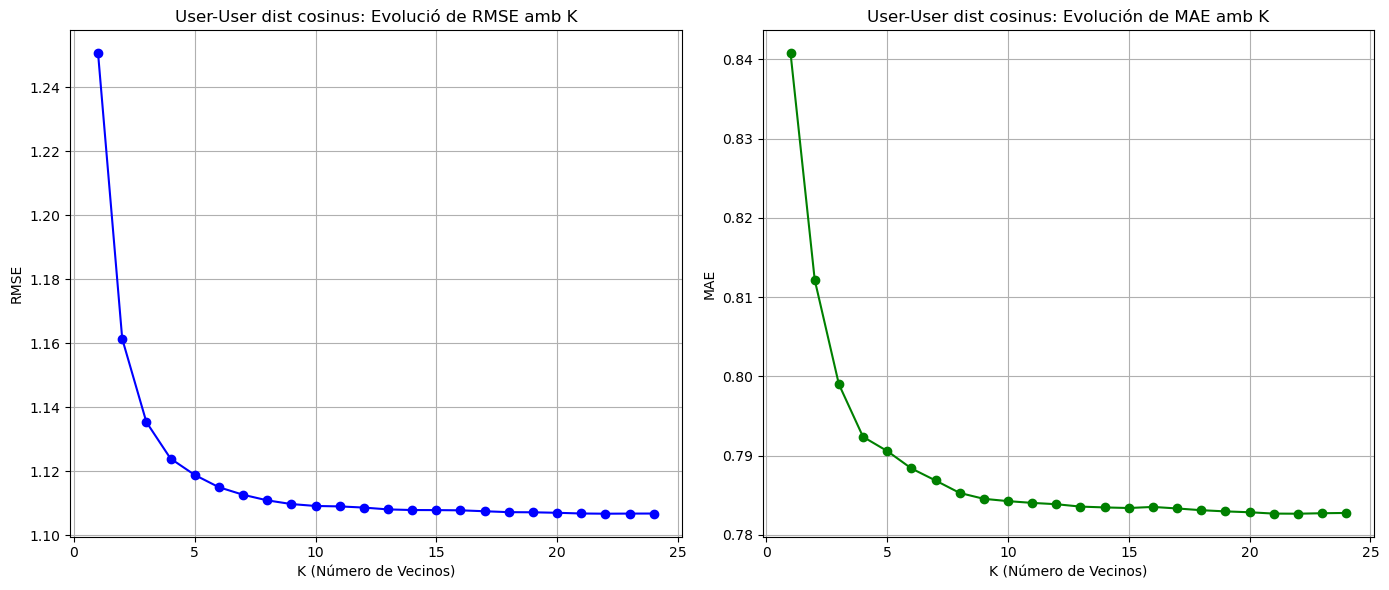

In [96]:
k_values = list(range(1, 25))  # Valores de K de 1 a 50
rmse_values = []
mae_values = []

# Probar diferentes valores de K
for k in k_values:
    # Configuración del modelo KNN con el valor de K actual
    sim_options = {'name': 'cosine', 'user_based': True}
    model = KNNBasic(k=k, sim_options=sim_options)
    
    # Ajustar el modelo y hacer predicciones
    model.fit(trainset)
    predictions = model.test(testset)
    
    # Calcular RMSE y MAE
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)
    
    # Guardar los resultados
    rmse_values.append(rmse)
    mae_values.append(mae)

# Graficar RMSE y MAE
plt.figure(figsize=(14, 6))

# RMSE
plt.subplot(1, 2, 1)
plt.plot(k_values, rmse_values, label='RMSE', color='blue', marker='o')
plt.title('User-User dist cosinus: Evolució de RMSE amb K')
plt.xlabel('K (Número de Vecinos)')
plt.ylabel('RMSE')
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(k_values, mae_values, label='MAE', color='green', marker='o')
plt.title('User-User dist cosinus: Evolución de MAE amb K')
plt.xlabel('K (Número de Vecinos)')
plt.ylabel('MAE')
plt.grid(True)

plt.tight_layout()
plt.show()

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1262
MAE:  0.8329
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1004
MAE:  0.8246
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0947
MAE:  0.8221
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0928
MAE:  0.8214
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0917
MAE:  0.8207
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0913
MAE:  0.8205
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0909
MAE:  0.8203
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0908
MAE:  0.8202
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0907
MAE:  0.8201
Computing the pearson similarity matrix...
Done computing similarity matr

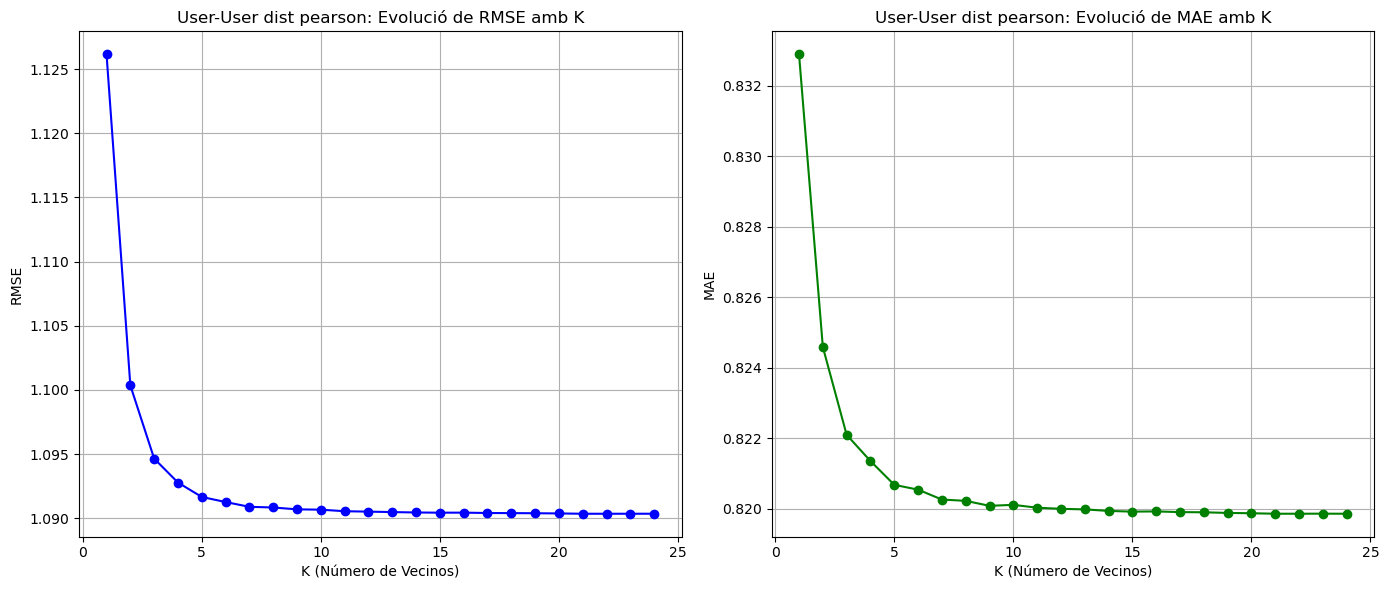

In [97]:
k_values = list(range(1, 25))  # Valores de K de 1 a 50
rmse_values = []
mae_values = []

# Probar diferentes valores de K
for k in k_values:
    # Configuración del modelo KNN con el valor de K actual
    sim_options = {'name': 'pearson', 'user_based': True}
    model = KNNBasic(k=k, sim_options=sim_options)
    
    # Ajustar el modelo y hacer predicciones
    model.fit(trainset)
    predictions = model.test(testset)
    
    # Calcular RMSE y MAE
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)
    
    # Guardar los resultados
    rmse_values.append(rmse)
    mae_values.append(mae)

# Graficar RMSE y MAE
plt.figure(figsize=(14, 6))

# RMSE
plt.subplot(1, 2, 1)
plt.plot(k_values, rmse_values, label='RMSE', color='blue', marker='o')
plt.title('User-User dist pearson: Evolució de RMSE amb K')
plt.xlabel('K (Número de Vecinos)')
plt.ylabel('RMSE')
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(k_values, mae_values, label='MAE', color='green', marker='o')
plt.title('User-User dist pearson: Evolució de MAE amb K')
plt.xlabel('K (Número de Vecinos)')
plt.ylabel('MAE')
plt.grid(True)

plt.tight_layout()
plt.show()

RMSE: 1.0863
RMSE en el testset: 1.0862879817932072
MAE:  0.7798
MAE en el testset: 0.7798487977828664
RMSE: 1.0747
RMSE en el testset: 1.0747241709210507
MAE:  0.7746
MAE en el testset: 0.7746209485434944


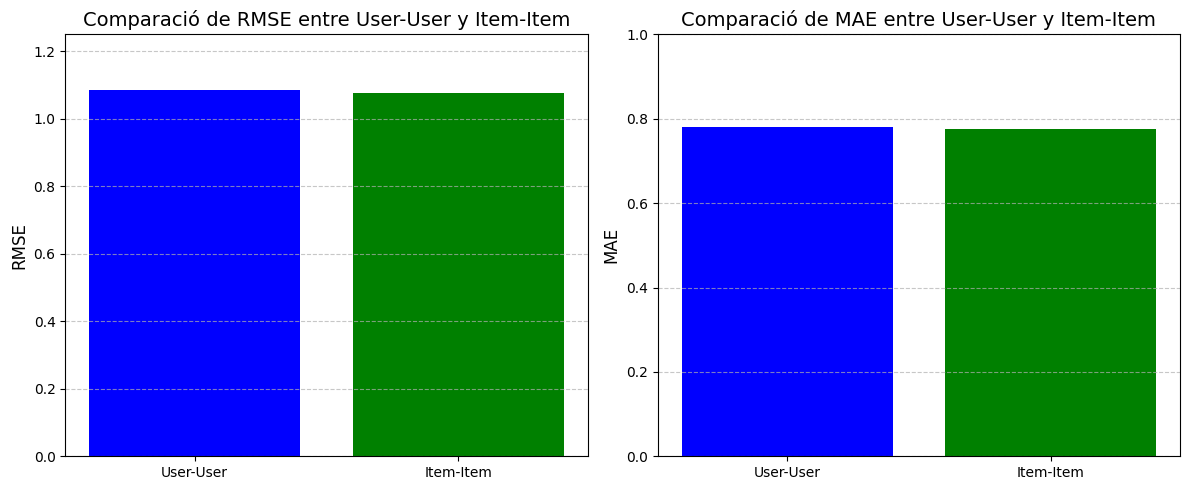

In [34]:
# Evaluar el RMSE en las predicciones del testset
rmse_c_u = accuracy.rmse(predictions_cosinus_user)
print(f'RMSE en el testset: {rmse_c_u}')

# Evaluar el MAE en las predicciones del testset
mae_c_u = accuracy.mae(predictions_cosinus_user)
print(f'MAE en el testset: {mae_c_u}')

# Evaluar el RMSE en las predicciones del testset
rmse_c_i = accuracy.rmse(predictions_cosinus_user_item)
print(f'RMSE en el testset: {rmse_c_i}')

# Evaluar el MAE en las predicciones del testset
mae_c_i = accuracy.mae(predictions_cosinus_user_item)
print(f'MAE en el testset: {mae_c_i}')

# Datos simulados de las métricas
models = ['User-User', 'Item-Item']
rmse_values = [rmse_c_u, rmse_c_i]  # RMSE para User-User y Item-Item
mae_values = [mae_c_u, mae_c_i]   # MAE para User-User y Item-Item

# Gráfico 1: Comparación de RMSE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(models, rmse_values, color=['blue', 'green'])
plt.title('Comparació de RMSE entre User-User y Item-Item', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.ylim(0, 1.25)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico 2: Comparación de MAE
plt.subplot(1, 2, 2)
plt.bar(models, mae_values, color=['blue', 'green'])
plt.title('Comparació de MAE entre User-User y Item-Item', fontsize=14)
plt.ylabel('MAE', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar los gráficos
plt.tight_layout()
plt.show()

RMSE: 1.0863
RMSE en el testset: 1.0862879817932072
MAE:  0.7798
MAE en el testset: 0.7798487977828664
RMSE: 1.0747
RMSE en el testset: 1.0747241709210507
MAE:  0.7746
MAE en el testset: 0.7746209485434944
RMSE: 0.9664
RMSE en el testset: 0.9663640530928547
MAE:  0.7148
MAE en el testset: 0.7147512075164083


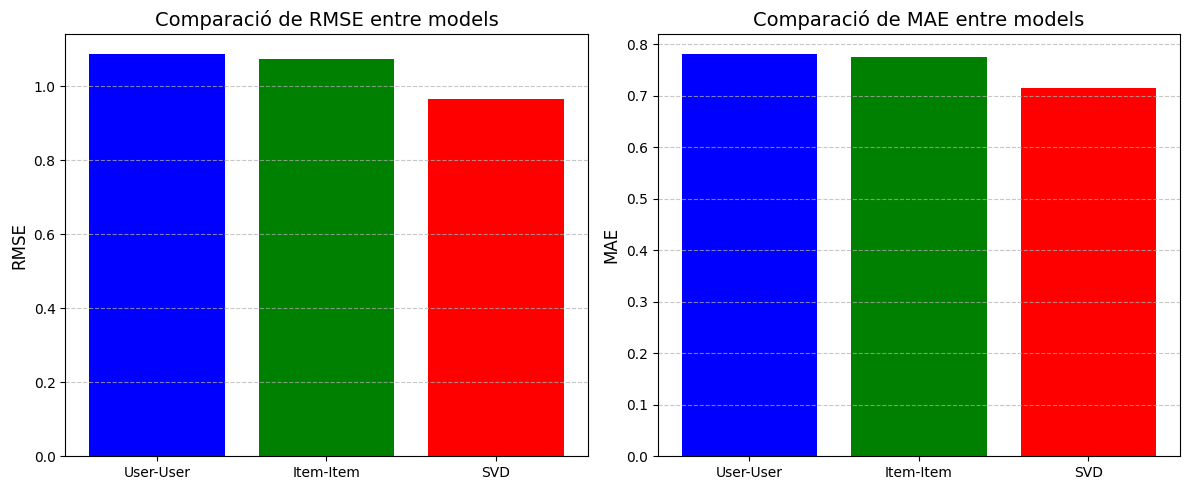

In [35]:
# Evaluar el RMSE en las predicciones del testset
rmse_c_u = accuracy.rmse(predictions_cosinus_user)
print(f'RMSE en el testset: {rmse_c_u}')

# Evaluar el MAE en las predicciones del testset
mae_c_u = accuracy.mae(predictions_cosinus_user)
print(f'MAE en el testset: {mae_c_u}')

# Evaluar el RMSE en las predicciones del testset
rmse_c_i = accuracy.rmse(predictions_cosinus_user_item)
print(f'RMSE en el testset: {rmse_c_i}')

# Evaluar el MAE en las predicciones del testset
mae_c_i = accuracy.mae(predictions_cosinus_user_item)
print(f'MAE en el testset: {mae_c_i}')

# Evaluar el RMSE en las predicciones del testset
rmse_svd = accuracy.rmse(pred)
print(f'RMSE en el testset: {rmse_svd}')

# Evaluar el MAE en las predicciones del testset
mae_svd = accuracy.mae(pred)
print(f'MAE en el testset: {mae_svd}')

# Añadir valores del modelo SVD
models = ['User-User', 'Item-Item', 'SVD']
rmse_values = [rmse_c_u, rmse_c_i, rmse_svd]  # RMSE para User-User y Item-Item
mae_values = [mae_c_u, mae_c_i, mae_svd]

# Crear gráfico comparativo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(models, rmse_values, color=['blue', 'green', 'red'])
plt.title('Comparació de RMSE entre models', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.bar(models, mae_values, color=['blue', 'green', 'red'])
plt.title('Comparació de MAE entre models', fontsize=14)
plt.ylabel('MAE', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [28]:
def precision_recall_at_k(predictions, k=10, threshold=4):
    """
    Calcula Precision@K y Recall@K para las predicciones dadas.
    """
    # Mapear cada usuario a los ítems recomendados
    user_recs = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_recs[uid].append((iid, est, true_r))
    
    # Ordenar las predicciones por calificación estimada y limitar a las top-k
    for uid, user_ratings in user_recs.items():
        user_recs[uid] = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:k]
    
    precisions = {}
    recalls = {}
    for uid, user_ratings in user_recs.items():
        # Calcular ítems recomendados relevantes
        recommended_and_relevant = [
            (iid, est) for (iid, est, true_r) in user_ratings if true_r >= threshold
        ]
        
        # Total de ítems relevantes en el conjunto de verdad
        relevant_total = sum(
            1 for u, _, true_r, _, _ in predictions if u == uid and true_r >= threshold
        )
        
        # Precision y Recall
        precisions[uid] = len(recommended_and_relevant) / k if k > 0 else 0
        recalls[uid] = len(recommended_and_relevant) / relevant_total if relevant_total > 0 else 0
    
    return precisions, recalls



# Calcular Precision@K y Recall@K SVD
precisions_svd, recalls_svd = precision_recall_at_k(pred, k=10, threshold=3.5)
# Promedio de las métricas
avg_precision_svd = sum(precisions_svd.values()) / len(precisions_svd)
avg_recall_svd = sum(recalls_svd.values()) / len(recalls_svd)

# Calcular Precision@K y Recall@K USER-USER
precisions_c_u, recalls_c_u = precision_recall_at_k(predictions_cosinus_user, k=10, threshold=3.5)
# Promedio de las métricas
avg_precision_c_u = sum(precisions_c_u.values()) / len(precisions_c_u)
avg_recall_c_u = sum(recalls_c_u.values()) / len(recalls_c_u)

# Calcular Precision@K y Recall@K USER-USER
precisions_c_i, recalls_c_i = precision_recall_at_k(predictions_cosinus_user_item, k=10, threshold=3.5)
# Promedio de las métricas
avg_precision_c_i = sum(precisions_c_i.values()) / len(precisions_c_i)
avg_recall_c_i = sum(recalls_c_i.values()) / len(recalls_c_i)
print(f'Precision@10: {avg_precision_svd:.4f}')
print(f'Recall@10: {avg_recall_svd:.4f}')
print(f'Precision@10: {avg_precision_c_u:.4f}')
print(f'Recall@10: {avg_recall_c_u:.4f}')
print(f'Precision@10: {avg_precision_c_i:.4f}')
print(f'Recall@10: {avg_recall_c_i:.4f}')

Precision@10: 0.8163
Recall@10: 0.7294
Precision@10: 0.8163
Recall@10: 0.7300
Precision@10: 0.7954
Recall@10: 0.7123


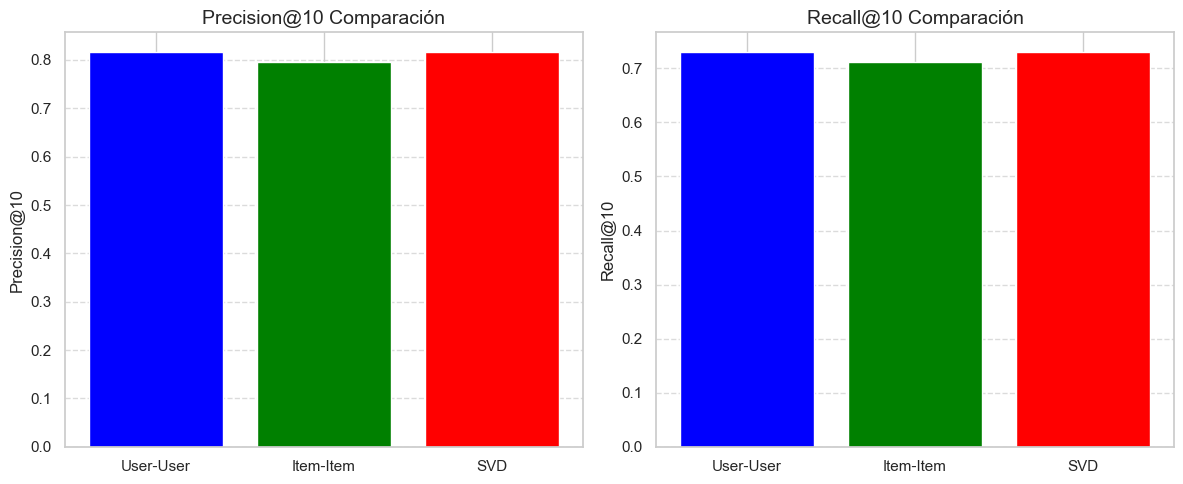

In [29]:
# Datos de ejemplo para gráficos (cambiar por valores reales)
models = ['User-User', 'Item-Item', 'SVD']
precision_values = [avg_precision_c_u, avg_precision_c_i, avg_precision_svd]  # Sustituir avg_precision con el valor real de SVD
recall_values = [avg_recall_c_u, avg_recall_c_i, avg_recall_svd]       # Sustituir avg_recall con el valor real de SVD

# Gráfico comparativo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(models, precision_values, color=['blue', 'green', 'red'])
plt.title('Precision@10 Comparación', fontsize=14)
plt.ylabel('Precision@10', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.bar(models, recall_values, color=['blue', 'green', 'red'])
plt.title('Recall@10 Comparación', fontsize=14)
plt.ylabel('Recall@10', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


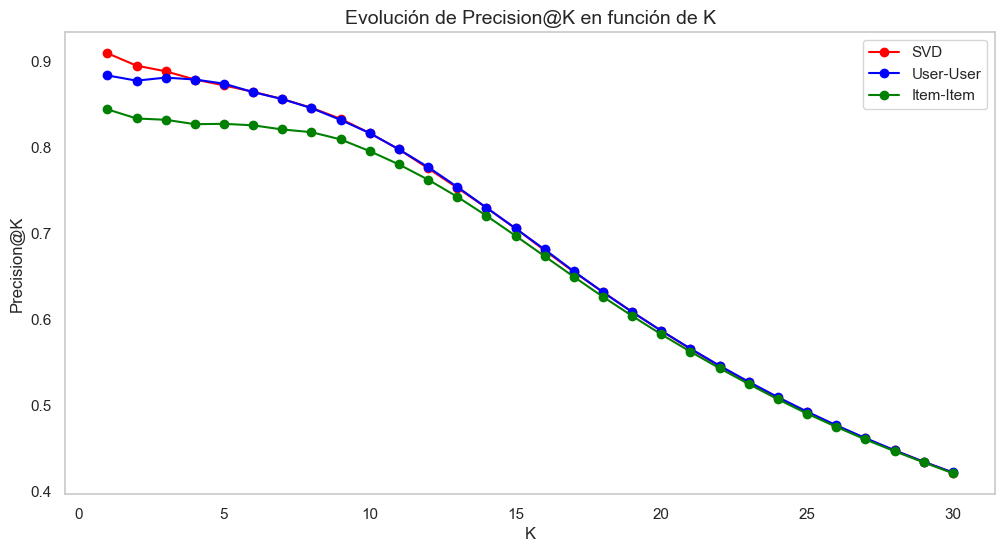

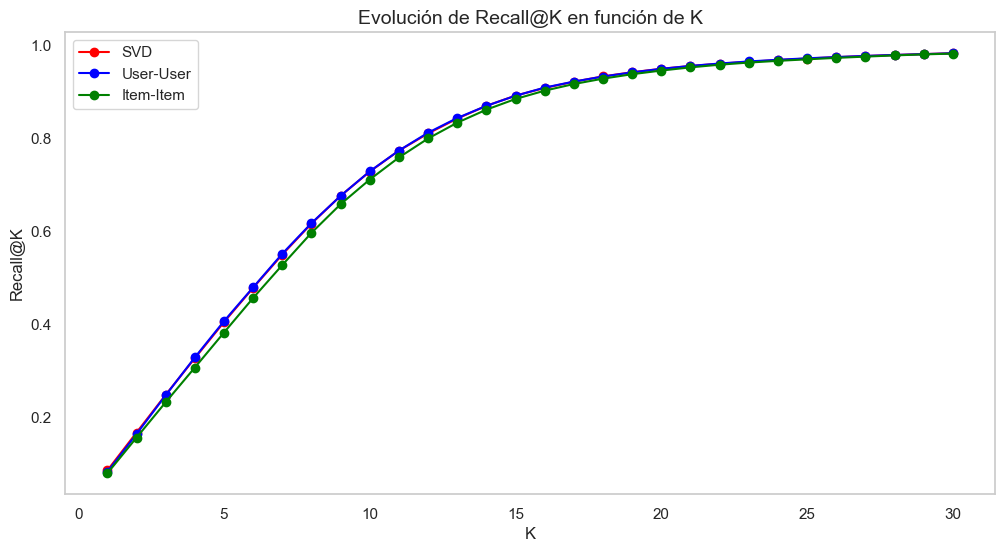

In [33]:
def precision_recall_by_k(predictions, max_k=30, threshold=3.5):
    """
    Calcula Precision@K y Recall@K para valores de K desde 1 hasta max_k.
    """
    precision_at_k = []
    recall_at_k = []

    for k in range(1, max_k + 1):
        precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=threshold)
        avg_precision = sum(precisions.values()) / len(precisions)
        avg_recall = sum(recalls.values()) / len(recalls)
        
        precision_at_k.append(avg_precision)
        recall_at_k.append(avg_recall)

    return precision_at_k, recall_at_k

# Calcular para SVD
max_k = 30
precision_k_svd, recall_k_svd = precision_recall_by_k(pred, max_k=max_k)
precision_k_c_i, recall_k_c_i = precision_recall_by_k(predictions_cosinus_user_item, max_k=max_k)
precision_k_c_u, recall_k_c_u = precision_recall_by_k(predictions_cosinus_user, max_k=max_k)
# (Repite este cálculo para User-User e Item-Item si es necesario)
# Valores de K
k_values = list(range(1, max_k + 1))

# Graficar Precision@K
plt.figure(figsize=(12, 6))
plt.plot(k_values, precision_k_svd, label='SVD', marker='o', color='red')
plt.plot(k_values, precision_k_c_u, label='User-User', marker='o', color='blue')
plt.plot(k_values, precision_k_c_i, label='Item-Item', marker='o', color='green')
plt.title('Evolución de Precision@K en función de K', fontsize=14)
plt.xlabel('K', fontsize=12)
plt.ylabel('Precision@K', fontsize=12)
plt.legend()
plt.grid()
plt.show()

# Graficar Recall@K
plt.figure(figsize=(12, 6))
plt.plot(k_values, recall_k_svd, label='SVD', marker='o', color='red')
plt.plot(k_values, recall_k_c_u, label='User-User', marker='o', color='blue')
plt.plot(k_values, recall_k_c_i, label='Item-Item', marker='o', color='green')
plt.title('Evolución de Recall@K en función de K', fontsize=14)
plt.xlabel('K', fontsize=12)
plt.ylabel('Recall@K', fontsize=12)
plt.legend()
plt.grid()
plt.show()


In [101]:
#Model cosinus
model_cosinus_i = KNNBasic(sim_options=sim_options_cosinus_items)
model_cosinus_u = KNNBasic(sim_options=sim_options_cosinus)
model_pearson_u = KNNBasic(sim_options=sim_options_pearson)
model_pearson_i = KNNBasic(sim_options=sim_options_pearson_items)
# Realizar validación cruzada con 5 particiones
#results_cosine = cross_validate(model_cosinus, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Evaluar el modelo en el testset (hacer predicciones)
model_cosinus_i.fit(trainset)
model_cosinus_u.fit(trainset)
model_pearson_u.fit(trainset)
model_pearson_i.fit(trainset)

predictions_cosinus_i = model_cosinus_i.test(testset)
predictions_cosinus_u = model_cosinus_u.test(testset)
predictions_person_u = model_pearson_u.test(testset)
predictions_person_i = model_pearson_i.test(testset)
pred = svd.test(testset)

##COSINUS
# Evaluar el RMSE en las predicciones del testset
rmse_cosinus_u = accuracy.rmse(predictions_cosinus_u)
print(f'RMSE con similitud de Pearson en el testset: {rmse_cosinus_u}')

# Evaluar el MAE en las predicciones del testset
mae_cosinus_u = accuracy.mae(predictions_cosinus_u)
print(f'MAE con similitud de Pearson en el testset: {mae_cosinus_u}')

##PEARSON
# Evaluar el RMSE en las predicciones del testset
rmse_pearson_u = accuracy.rmse(predictions_person_u)
print(f'RMSE con similitud de Pearson en el testset: {rmse_pearson_u}')

# Evaluar el MAE en las predicciones del testset
mae_pearson_u = accuracy.mae(predictions_person_u)
print(f'MAE con similitud de Pearson en el testset: {mae_pearson_u}')

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1066
RMSE con similitud de Pearson en el testset: 1.1066289876457045
MAE:  0.7828
MAE con similitud de Pearson en el testset: 0.782827060475207
RMSE: 1.0904
RMSE con similitud de Pearson en el testset: 1.0903682613079733
MAE:  0.8198
MAE con similitud de Pearson en el testset: 0.8198484666222752


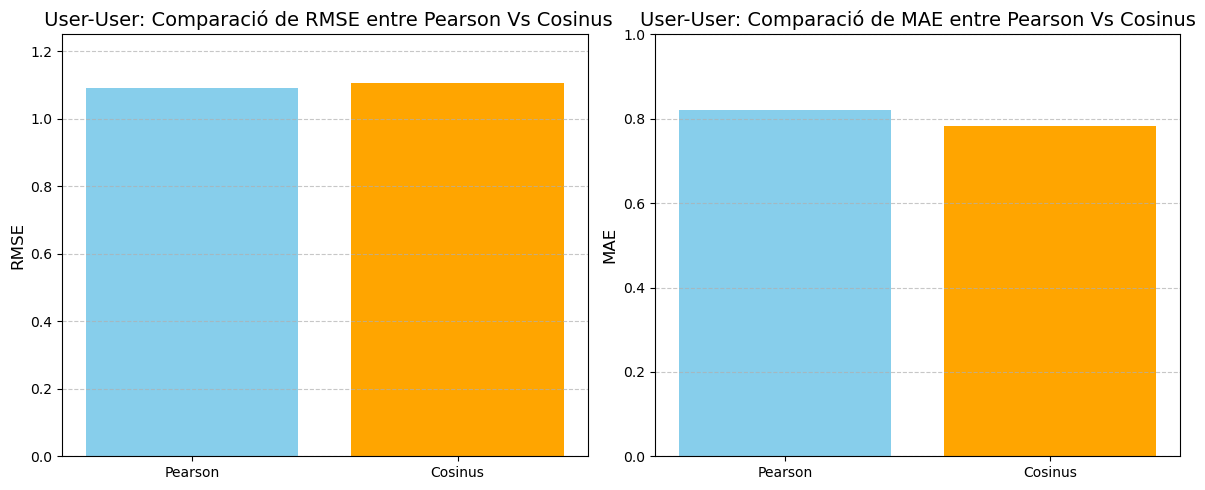

In [110]:
###USERUSER WHICH IS BETTER?? PREARSON O COSINUS

##Visualización cosinus cual es mejor si item-item o user-user
import matplotlib.pyplot as plt

# Datos simulados de las métricas
models = ['Pearson', 'Cosinus']
rmse_values = [rmse_pearson_u, rmse_cosinus_u]  # RMSE para User-User y Item-Item
mae_values = [mae_pearson_u, mae_cosinus_u]   # MAE para User-User y Item-Item

# Gráfico 1: Comparación de RMSE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(models, rmse_values, color=['skyblue', 'orange'])
plt.title(' User-User: Comparació de RMSE entre Pearson Vs Cosinus', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.ylim(0, 1.25)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico 2: Comparación de MAE
plt.subplot(1, 2, 2)
plt.bar(models, mae_values, color=['skyblue', 'orange'])
plt.title('User-User: Comparació de MAE entre Pearson Vs Cosinus', fontsize=14)
plt.ylabel('MAE', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar los gráficos
plt.tight_layout()
plt.show()

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0799
RMSE con similitud de Pearson en el testset: 1.0799257199165753
MAE:  0.7669
MAE con similitud de Pearson en el testset: 0.7669029305631778
RMSE: 1.0802
RMSE con similitud de Pearson en el testset: 1.080208297238385
MAE:  0.8189
MAE con similitud de Pearson en el testset: 0.818887152618858


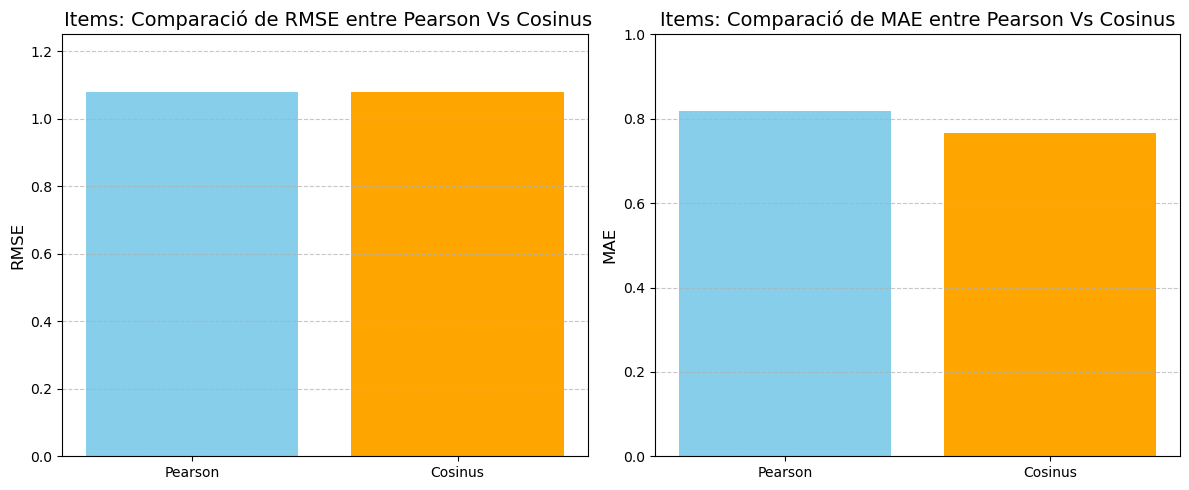

In [130]:
##ITEMSITEMS WHICH IS BETTER PEARSON O COSINUS??
#Model cosinus
model_cosinus_i = KNNBasic(sim_options=sim_options_cosinus_items)
model_pearson_i = KNNBasic(sim_options=sim_options_pearson_items)
# Realizar validación cruzada con 5 particiones
#results_cosine = cross_validate(model_cosinus, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Evaluar el modelo en el testset (hacer predicciones)
model_cosinus_i.fit(trainset)
model_pearson_i.fit(trainset)
predictions_cosinus_i = model_cosinus_i.test(testset)
predictions_person_i = model_pearson_i.test(testset)

##COSINUS
# Evaluar el RMSE en las predicciones del testset
rmse_cosinus_i = accuracy.rmse(predictions_cosinus_i)
print(f'RMSE con similitud de Pearson en el testset: {rmse_cosinus_i}')

# Evaluar el MAE en las predicciones del testset
mae_cosinus_i = accuracy.mae(predictions_cosinus_i)
print(f'MAE con similitud de Pearson en el testset: {mae_cosinus_i}')

##PEARSON
# Evaluar el RMSE en las predicciones del testset
rmse_pearson_i = accuracy.rmse(predictions_person_i)
print(f'RMSE con similitud de Pearson en el testset: {rmse_pearson_i}')

# Evaluar el MAE en las predicciones del testset
mae_pearson_i = accuracy.mae(predictions_person_i)
print(f'MAE con similitud de Pearson en el testset: {mae_pearson_i}')

##Visualización cosinus cual es mejor si item-item o user-user
import matplotlib.pyplot as plt

# Datos simulados de las métricas
models = ['Pearson', 'Cosinus']
rmse_values = [rmse_pearson_i, rmse_cosinus_i]  # RMSE para User-User y Item-Item
mae_values = [mae_pearson_i, mae_cosinus_i]   # MAE para User-User y Item-Item

# Gráfico 1: Comparación de RMSE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(models, rmse_values, color=['skyblue', 'orange'])
plt.title(' Items: Comparació de RMSE entre Pearson Vs Cosinus', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.ylim(0, 1.25)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico 2: Comparación de MAE
plt.subplot(1, 2, 2)
plt.bar(models, mae_values, color=['skyblue', 'orange'])
plt.title('Items: Comparació de MAE entre Pearson Vs Cosinus', fontsize=14)
plt.ylabel('MAE', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [51]:
#Model Pearson
model_pearson = KNNBasic(sim_options=sim_options_pearson)

# Realizar validación cruzada con 5 particiones
#results_pearson = cross_validate(model_pearson, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Evaluar el modelo en el testset (hacer predicciones)
model_pearson.fit(trainset)
predictions_pearson_user = model_pearson.test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
# Evaluar el RMSE en las predicciones del testset
rmse_pearson = accuracy.rmse(predictions_pearson_user)
print(f'RMSE con similitud de Pearson en el testset: {rmse_pearson}')

# Evaluar el MAE en las predicciones del testset
mae_pearson = accuracy.mae(predictions_pearson_user)
print(f'MAE con similitud de Pearson en el testset: {mae_pearson}')


Projecte:
ordre
user user
500 lines
cosinus 
pearson


In [ ]:
###Funcionnnnnns#####
from surprise import accuracy
from sklearn.metrics import ndcg_score
import numpy as np

def calculate_ndcg(predictions, k=10):
    """Calcula el NDCG per a un conjunt de prediccions."""
    true_relevance = []
    scores = []
    
    for uid, iid, true_r, est, _ in predictions:
        true_relevance.append(true_r)
        scores.append(est)

    # Transformar en format compatible amb sklearn.metrics.ndcg_score
    true_relevance = np.array([true_relevance])  # Ha de ser 2D
    scores = np.array([scores])  # Ha de ser 2D

    return ndcg_score(true_relevance, scores, k=k)

def calculate_mrr(predictions):
    """Calcula el Mean Reciprocal Rank (MRR) per a les prediccions."""
    reciprocal_ranks = []

    for uid, iid, true_r, est, _ in predictions:
        rank = 1.0 / (1 + abs(true_r - est))  # Reciprocal rank basat en la diferència
        reciprocal_ranks.append(rank)

    return np.mean(reciprocal_ranks)

def precision_at_k(predictions, k=10):
    """Calcula la precisió@K."""
    top_k = sorted(predictions, key=lambda x: x[3], reverse=True)[:k]  # Ordenar per est
    relevant = [1 if true_r >= 4 else 0 for uid, iid, true_r, est, _ in top_k]

    return sum(relevant) / k

def recall_at_k(predictions, k=10):
    """Calcula el recall@K."""
    top_k = sorted(predictions, key=lambda x: x[3], reverse=True)[:k]
    relevant = [1 if true_r >= 4 else 0 for uid, iid, true_r, est, _ in top_k]
    total_relevant = sum(1 for uid, iid, true_r, est, _ in predictions if true_r >= 4)

    return sum(relevant) / total_relevant if total_relevant > 0 else 0

In [ ]:
#filtered_dataset Matriu filtrada dels usuaris. 
# 1. Matriu agafem aleatoriament 500 files.
unique_users = filtered_dataset['userId'].unique()

#Seleccionar aleatoriamente 500 usuarios (o menos si hay menos usuarios disponibles)
selected_users = np.random.choice(unique_users, size=min(500, len(unique_users)), replace=False)

#Filtrar el DataFrame para mantener solo los usuarios seleccionados
dataset_500 = filtered_dataset[filtered_dataset['userId'].isin(selected_users)]
dataset_500.shape
print("Total number of users:", dataset_500.userId.nunique())

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(dataset_500[['userId', 'productId', 'rating']], reader)
# Convierte el dataset filtrado en formato Surprise
# Convierte el dataset en un objeto "DatasetAutoFolds" que puede dividirse
full_trainset = data.build_full_trainset()
trainset, testset = train_test_split(data, test_size=0.2)

##COSINUS
model_cosinus_u = KNNBasic(sim_options=sim_options_cosinus)
model_cosinus_u.fit(trainset)
predicted_cosinus = model_cosinus_uosinus.test(testset)

##PEARSON
model_pearson_u = KNNBasic(sim_options=sim_options_pearson)
model_pearson_u.fit(trainset)
predicted_pearson = model_pearson_u.test(testset)

In [ ]:
###Fer una grafica mirant els errors de cada uno con diferentes ks 
##ERRORS - Cosinus
# Evaluar el RMSE en las predicciones del testset
rmse = accuracy.rmse(predictions_cosinus_user)
print(f'RMSE en el testset: {rmse}')

# Evaluar el MAE en las predicciones del testset
mae = accuracy.mae(predictions_cosinus_user)
print(f'MAE en el testset: {mae}')

ndcg = calculate_ndcg(predictions_cosinus_user, k=10)
#print(f'NDCG@10 en el testset: {ndcg}')

mrr = calculate_mrr(predictions_cosinus_user)
print(f'MRR en el testset: {mrr}')

precision = precision_at_k(predictions_cosinus_user, k=10)
print(f'Precision@10 en el testset: {precision}')

recall = recall_at_k(predictions_cosinus_user, k=10)
print(f'Recall@10 en el testset: {recall}')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que ya tienes definidas las funciones calculate_ndcg, calculate_mrr, precision_at_k y recall_at_k
def plot_errors_vs_k(predictions, k_values):
    rmse_values = []
    mae_values = []
    ndcg_values = []
    mrr_values = []
    precision_values = []
    recall_values = []

    for k in k_values:
        # RMSE y MAE no dependen de k, pero se incluyen para mantener consistencia en las gráficas
        rmse_values.append(accuracy.rmse(predictions, verbose=False))
        mae_values.append(accuracy.mae(predictions, verbose=False))
        
        # NDCG, MRR, Precision@k y Recall@k
        ndcg_values.append(calculate_ndcg(predictions, k=k))
        mrr_values.append(calculate_mrr(predictions))  # MRR no cambia con k si calculas por usuario
        precision_values.append(precision_at_k(predictions, k=k))
        recall_values.append(recall_at_k(predictions, k=k))

    # Crear las gráficas
    plt.figure(figsize=(12, 8))

    # RMSE y MAE
    plt.plot(k_values, rmse_values, label='RMSE', marker='o')
    plt.plot(k_values, mae_values, label='MAE', marker='o')

    # NDCG, MRR, Precision y Recall
    plt.plot(k_values, ndcg_values, label='NDCG', marker='o')
    plt.plot(k_values, mrr_values, label='MRR', marker='o')
    plt.plot(k_values, precision_values, label='Precision@k', marker='o')
    plt.plot(k_values, recall_values, label='Recall@k', marker='o')

    # Configuración de la gráfica
    plt.xlabel('K')
    plt.ylabel('Error/Métrica')
    plt.title('Evolución de los errores y métricas según K')
    plt.legend()
    plt.grid(True)
    plt.show()

# Ejemplo de uso
k_values = list(range(1,100))  # Valores de k del 1 al 20
plot_errors_vs_k(pred, k_values)


In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que ya tienes definidas las funciones calculate_ndcg, calculate_mrr, precision_at_k y recall_at_k
def plot_errors_vs_k(predictions, k_values):
    # Calcular RMSE y MAE una sola vez (no dependen de k)
    rmse_value = accuracy.rmse(predictions, verbose=False)
    mae_value = accuracy.mae(predictions, verbose=False)

    ndcg_values = []
    mrr_values = []
    precision_values = []
    recall_values = []

    for k in k_values:
        # NDCG, MRR, Precision@k y Recall@k
        ndcg_values.append(calculate_ndcg(predictions, k=k))
        mrr_values.append(calculate_mrr(predictions))  # MRR no cambia con k si calculas por usuario
        precision_values.append(precision_at_k(predictions, k=k))
        recall_values.append(recall_at_k(predictions, k=k))

    # Crear las gráficas
    plt.figure(figsize=(12, 8))

    # RMSE y MAE
    plt.axhline(y=rmse_value, color='blue', linestyle='--', label='RMSE')
    plt.axhline(y=mae_value, color='orange', linestyle='--', label='MAE')

    # NDCG, MRR, Precision y Recall
    plt.plot(k_values, ndcg_values, label='NDCG', marker='o')
    plt.plot(k_values, mrr_values, label='MRR', marker='o')
    plt.plot(k_values, precision_values, label='Precision@k', marker='o')
    plt.plot(k_values, recall_values, label='Recall@k', marker='o')

    # Configuración de la gráfica
    plt.xlabel('K')
    plt.ylabel('Error/Métrica')
    plt.title('Evolución de los errores y métricas según K')
    plt.legend()
    plt.grid(True)
    plt.show()

# Ejemplo de uso
k_values = list(range(1, 101))  # Valores de k del 1 al 100
plot_errors_vs_k(predictions_cosinus_user, k_values)


NameError: name 'calculate_ndcg' is not defined

In [127]:
from collections import defaultdict

# Función para obtener las recomendaciones por usuario
def get_top_n(predictions, n=10, threshold=4.0):
    """ Devuelve las N principales recomendaciones por usuario """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        if est >= threshold:  # Umbral para considerar relevante
            top_n[uid].append((iid, est))
    
    # Ordenar las recomendaciones por puntuación estimada y limitar a N
    for uid, user_ratings in top_n.items():
        top_n[uid] = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n]
    
    return top_n

def precision_recall_at_k(top_n, testset, k=10, threshold=4.0):
    """Calcula Precision y Recall limitando a las top-k recomendaciones."""
    hits = 0
    total_relevant = 0
    total_recommended = 0

    # Crear un diccionario con los ítems relevantes reales
    relevant_items = defaultdict(set)
    for uid, iid, true_r in testset:
        if true_r >= threshold:  # Ítems relevantes reales
            relevant_items[uid].add(iid)

    for uid, user_ratings in top_n.items():
        # Limitar a las top-k recomendaciones
        recommended_items = set([iid for iid, _ in user_ratings[:k]])
        relevant = relevant_items[uid]

        # Contar los aciertos y totales
        hits += len(recommended_items & relevant)  # Intersección de relevantes
        total_recommended += len(recommended_items)
        total_relevant += len(relevant)

    precision = hits / total_recommended if total_recommended > 0 else 0
    recall = hits / total_relevant if total_relevant > 0 else 0

    return precision, recall


# Generar top-N recomendaciones (con un número alto de recomendaciones)
top_n = get_top_n(predictions_cosinus_i, n=80, threshold=4.0)

# Evaluar Precision y Recall para diferentes valores de k
for k in [5, 10, 20, 50]:
    precision, recall = precision_recall_at_k(top_n, testset, k=k, threshold=4.0)
    print(f"Precision@{k}: {precision:.4f}, Recall@{k}: {recall:.4f}")


Precision@5: 0.8398, Recall@5: 0.3763
Precision@10: 0.8379, Recall@10: 0.6446
Precision@20: 0.8439, Recall@20: 0.8191
Precision@50: 0.8459, Recall@50: 0.8764


In [32]:
import matplotlib.pyplot as plt

# Supongamos que estos son los 5 tipos de predicciones
models = {
    "Cosinus User-User": predictions_cosinus_u,
    "Cosinus Item-Item": predictions_cosinus_i,
    "Pearson User-User": predictions_pearson_user,
    "Pearson Item-Item": predictions_person_i,
    "Modelo SVD": pred
}

# Rango de valores de k
k_values = range(1, 50)

# Diccionarios para almacenar los resultados
precision_results = {model: [] for model in models.keys()}
recall_results = {model: [] for model in models.keys()}

# Calcular Precision y Recall para cada modelo y cada valor de k
for model_name, predictions in models.items():
    top_n = get_top_n(predictions, n=80, threshold=4.0)
    for k in k_values:
        precision, recall = precision_recall_at_k(top_n, testset, k=k, threshold=4.0)
        precision_results[model_name].append(precision)
        recall_results[model_name].append(recall)

# Graficar Precision y Recall
plt.figure(figsize=(14, 6))

# Subplot 1: Precision
plt.subplot(1, 2, 1)
for model_name, precisions in precision_results.items():
    plt.plot(k_values, precisions, marker='o', label=model_name)
plt.title("Evolució de Precisió segons k", fontsize=14)
plt.xlabel("k (Número de recomanacions)", fontsize=12)
plt.ylabel("Precisió", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Subplot 2: Recall
plt.subplot(1, 2, 2)
for model_name, recalls in recall_results.items():
    plt.plot(k_values, recalls, marker='o', label=model_name)
plt.title("Evolució de Recall segons k", fontsize=14)
plt.xlabel("k (Número de recomanacions)", fontsize=12)
plt.ylabel("Recall", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



NameError: name 'predictions_cosinus_u' is not defined

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

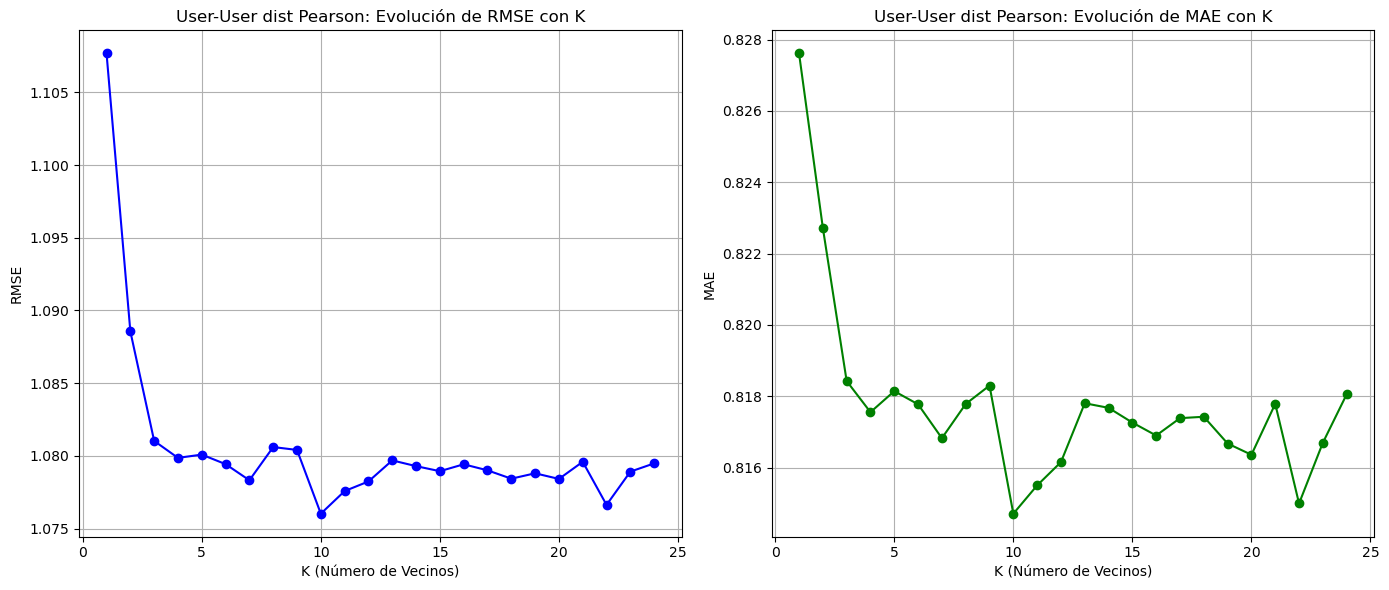

In [136]:
# Valores de K a probar
k_values = list(range(1, 25))  # Cambia el rango según sea necesario
rmse_values = []
mae_values = []

# Cargar datos
reader = Reader(line_format='user item rating timestamp', sep='\t')  # Personaliza si usas otro dataset

# Probar diferentes valores de K
for k in k_values:
    # Configuración del modelo KNN con User-User Pearson
    sim_options = {'name': 'pearson', 'user_based': False}
    model = KNNBasic(k=k, sim_options=sim_options)
    
    # Validación cruzada y obtención de resultados promedio
    cv_results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    
    # Guardar los resultados promedios
    rmse_values.append(cv_results['test_rmse'].mean())
    mae_values.append(cv_results['test_mae'].mean())

# Graficar RMSE y MAE
plt.figure(figsize=(14, 6))

# RMSE
plt.subplot(1, 2, 1)
plt.plot(k_values, rmse_values, label='RMSE', color='blue', marker='o')
plt.title('User-User dist Pearson: Evolución de RMSE con K')
plt.xlabel('K (Número de Vecinos)')
plt.ylabel('RMSE')
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(k_values, mae_values, label='MAE', color='green', marker='o')
plt.title('User-User dist Pearson: Evolución de MAE con K')
plt.xlabel('K (Número de Vecinos)')
plt.ylabel('MAE')
plt.grid(True)

plt.tight_layout()
plt.show()

In [222]:
###FUNCIO PER MESURAR ERROR DE CADA VALOR###
def separa_prediccions(prediccio):
    arr1 = []
    arr2 = []
    arr3 = []
    arr4 = []
    arr5 = []
    
    for n in prediccio:
        if n.r_ui == 1.0:
            arr1.append(n)
        if n.r_ui == 2.0:
            arr2.append(n)
        if n.r_ui == 3.0:
            arr3.append(n)
        if n.r_ui == 4.0:
            arr4.append(n)
        if n.r_ui == 5.0:
            arr5.append(n)
    return arr1, arr2, arr3, arr4, arr5

In [223]:
rmse1 = accuracy.rmse(arr1)
mae1 = accuracy.mae(arr1)
print("Errors RMSE predict 1.0", rmse1)
print("Errors MAE predict 1.0", mae1)
rmse2 = accuracy.rmse(arr2)
mae2 = accuracy.mae(arr2)
print("Errors RMSE predict 2.0", rmse2)
print("Errors MAE predict 2.0", mae2)
rmse3 = accuracy.rmse(arr3)
mae3 = accuracy.mae(arr3)
print("Errors RMSE predict 3.0", rmse3)
print("Errors MAE predict 3.0", mae3)
rmse4 = accuracy.rmse(arr4)
mae4 = accuracy.mae(arr4)
print("Errors RMSE predict 4.0", rmse4)
print("Errors MAE predict 4.0", mae4)
rmse5 = accuracy.rmse(arr5)
mae5 = accuracy.mae(arr5)
print("Errors RMSE predict 5.0", rmse5)
print("Errors MAE predict 5.0", mae5)
def calcul_RMSE_MAE_5_ratings(l):
    rmse_list = []
    mae_list = []
    for n in range(len(l)):
        rmse_list.append(accuracy.rmse(l[n]))
        mae_list.append(accuracy.mae(l[n]))
    return rmse_list, mae_list

RMSE: 3.2139
MAE:  3.1327
Errors RMSE predict 1.0 3.213902686527347
Errors MAE predict 1.0 3.132710240388415
RMSE: 2.2079
MAE:  2.1305
Errors RMSE predict 2.0 2.2078908978206133
Errors MAE predict 2.0 2.130488909367471
RMSE: 1.3002
MAE:  1.2206
Errors RMSE predict 3.0 1.3001711097785051
Errors MAE predict 3.0 1.2205796090086978
RMSE: 0.5360
MAE:  0.4163
Errors RMSE predict 4.0 0.5359694480596963
Errors MAE predict 4.0 0.4163470138952059
RMSE: 0.7655
MAE:  0.5917
Errors RMSE predict 5.0 0.7655230493439602
Errors MAE predict 5.0 0.5916934625237859


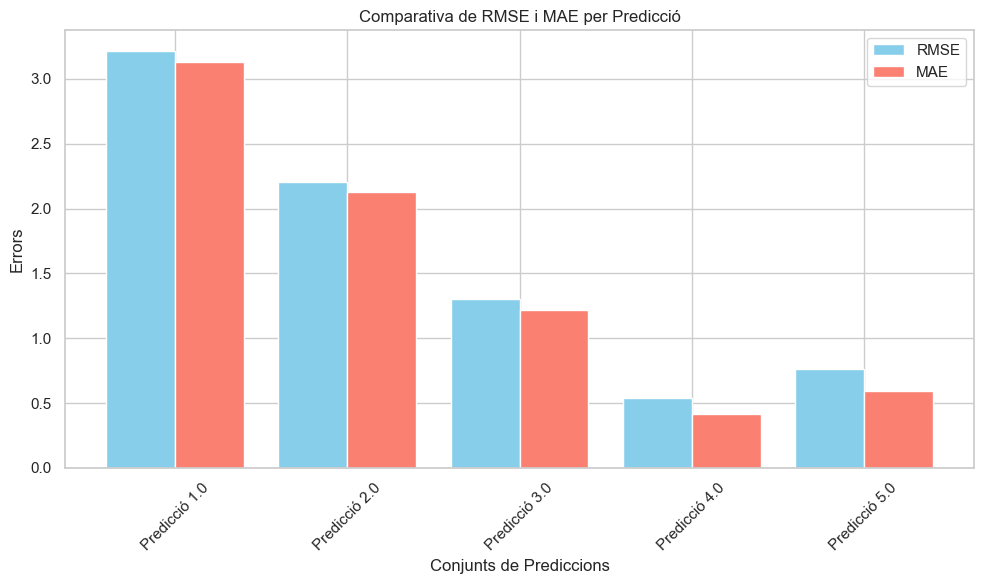

In [224]:
import matplotlib.pyplot as plt
import numpy as np

# Datos ficticios para RMSE y MAE
predicciones = ['Predicció 1.0', 'Predicció 2.0', 'Predicció 3.0', 'Predicció 4.0', 'Predicció 5.0']
rmse = [rmse1, rmse2, rmse3, rmse4, rmse5]
mae = [mae1, mae2, mae3, mae4, mae5]

# Posiciones en el eje x
x = np.arange(len(predicciones))

# Configuración de la gráfica
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, rmse, width=0.4, label='RMSE', color='skyblue')
plt.bar(x + 0.2, mae, width=0.4, label='MAE', color='salmon')

# Etiquetas y título
plt.xticks(x, predicciones, rotation=45)
plt.xlabel('Conjunts de Prediccions')
plt.ylabel('Errors')
plt.title('Comparativa de RMSE i MAE per Predicció')
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()


RMSE: 3.2413
MAE:  3.1701
RMSE: 2.1748
MAE:  2.0725
RMSE: 1.2602
MAE:  1.1562
RMSE: 0.6229
MAE:  0.4745
RMSE: 0.8113
MAE:  0.6055


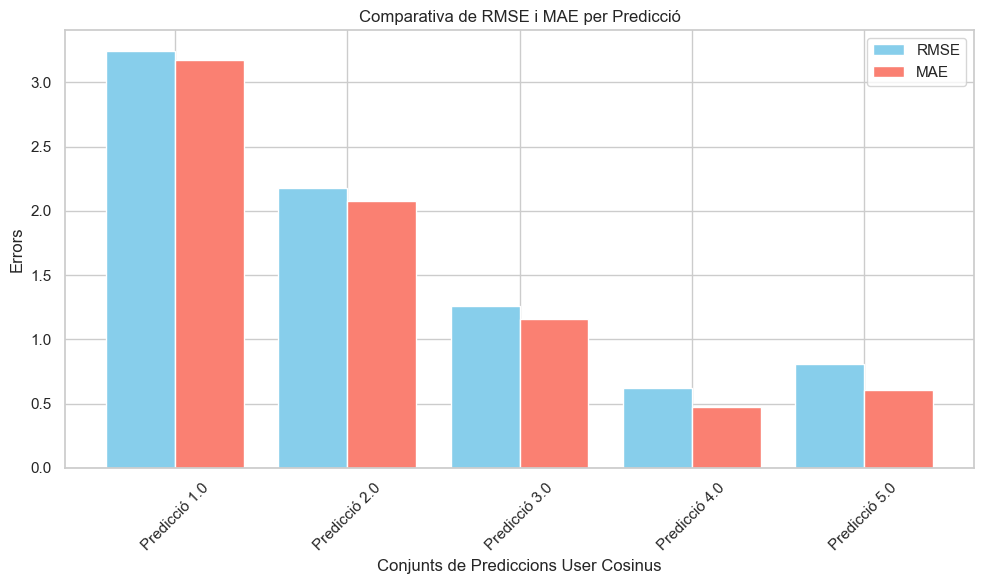

RMSE: 3.2464
MAE:  3.2191
RMSE: 2.1770
MAE:  2.1116
RMSE: 1.2516
MAE:  1.1888
RMSE: 0.5558
MAE:  0.4092
RMSE: 0.7949
MAE:  0.6888


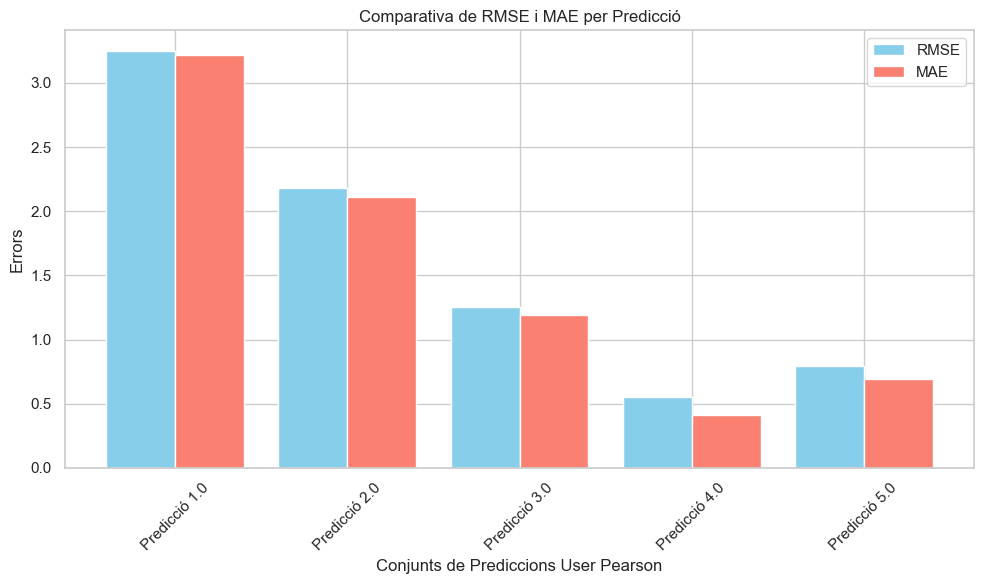

RMSE: 3.2139
MAE:  3.1327
RMSE: 2.2079
MAE:  2.1305
RMSE: 1.3002
MAE:  1.2206
RMSE: 0.5360
MAE:  0.4163
RMSE: 0.7655
MAE:  0.5917


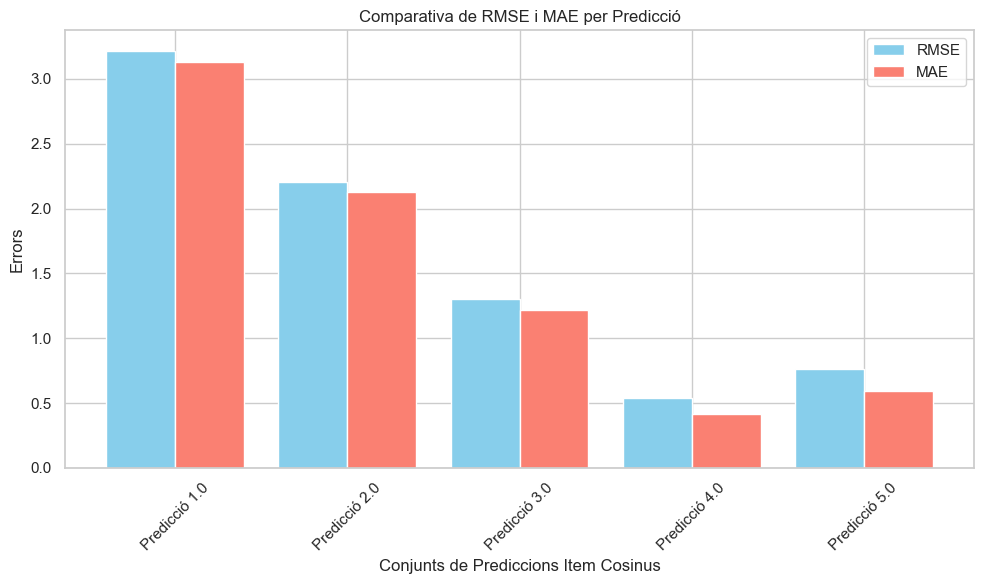

RMSE: 3.2519
MAE:  3.2268
RMSE: 2.2501
MAE:  2.2171
RMSE: 1.2767
MAE:  1.2306
RMSE: 0.4613
MAE:  0.3533
RMSE: 0.7748
MAE:  0.6974


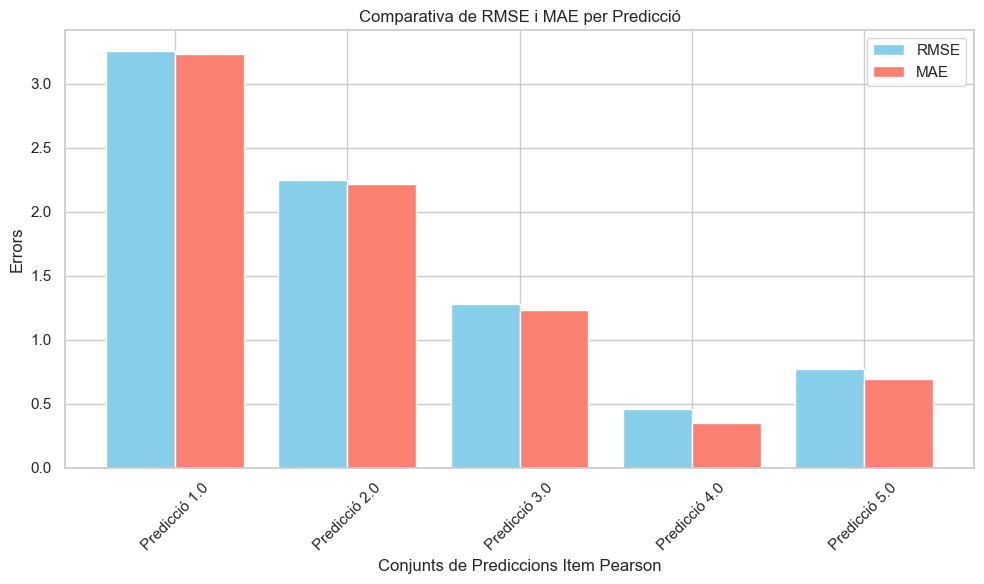

RMSE: 2.0214
MAE:  1.9592
RMSE: 1.3937
MAE:  1.3328
RMSE: 0.8122
MAE:  0.7467
RMSE: 0.3261
MAE:  0.2654
RMSE: 0.5010
MAE:  0.4259


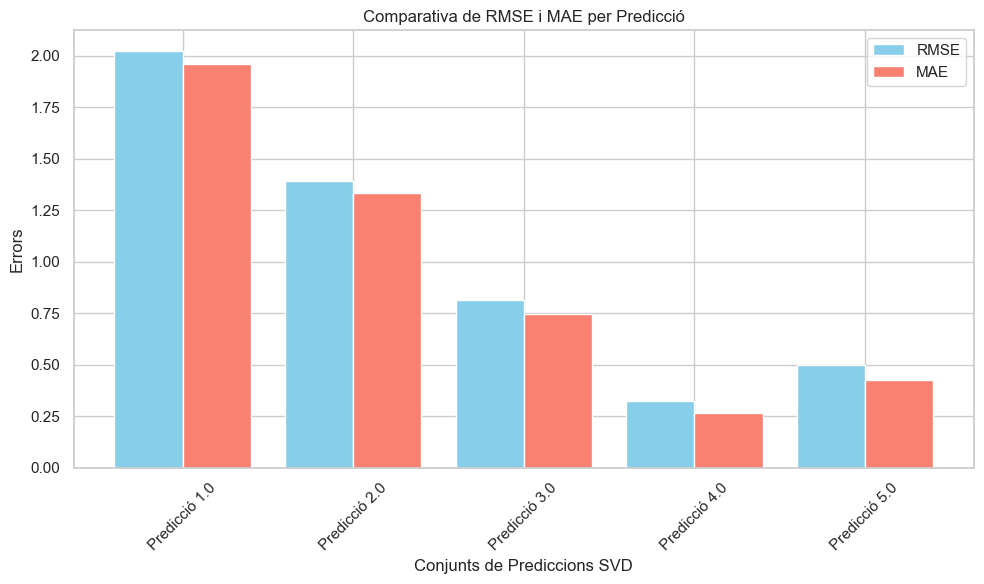

In [230]:
predicions_all_models_nom = ['User Cosinus', 'User Pearson', 'Item Cosinus', 'Item Pearson', 'SVD']
predicions_all_models = [predictions_cosinus_u, predictions_person_u, predictions_cosinus_i, predictions_person_i, pred]
for n in range(5):
    name = predicions_all_models_nom[n]
    predd = predicions_all_models[n]
    arr1, arr2, arr3, arr4, arr5 = separa_prediccions(predd)
    rmse_list, mae_list = calcul_RMSE_MAE_5_ratings([arr1, arr2, arr3, arr4, arr5])
    predicciones = ['Predicció 1.0', 'Predicció 2.0', 'Predicció 3.0', 'Predicció 4.0', 'Predicció 5.0']
    # Posiciones en el eje x
    x = np.arange(len(predicciones))
    # Configuración de la gráfica
    plt.figure(figsize=(10, 6))
    plt.bar(x - 0.2, rmse_list, width=0.4, label='RMSE', color='skyblue')
    plt.bar(x + 0.2, mae_list, width=0.4, label='MAE', color='salmon')
    
    # Etiquetas y título
    plt.xticks(x, predicciones, rotation=45)
    plt.xlabel(f'Conjunts de Prediccions {name}')
    plt.ylabel('Errors')
    plt.title('Comparativa de RMSE i MAE per Predicció')
    plt.legend()
    
    # Mostrar la gráfica
    plt.tight_layout()
    plt.show()
        
    
    

In [ ]:
import matplotlib.pyplot as plt

# Listas de Precision y Recall para tres modelos (suponiendo que estas listas ya están definidas)
# Los valores de Precision y Recall podrían venir de las predicciones en función de K.
precision_model_1 = precision_k_svd
recall_model_1 = recall_k_svd

precision_model_2 = precision_k_c_i
recall_model_2 = recall_k_c_i

precision_model_3 = precision_k_c_u
recall_model_3 = recall_k_c_u

# Crear un gráfico de dispersión (scatter plot) para cada modelo
plt.figure(figsize=(10, 6))

plt.scatter(precision_model_1, recall_model_1, color='blue', label='SVD', marker='o', s=100)
plt.scatter(precision_model_2, recall_model_2, color='green', label='Item-Item', marker='x', s=100)
plt.scatter(precision_model_3, recall_model_3, color='red', label='User-User', marker='^', s=100)

# Conectar los puntos con líneas para cada modelo
plt.plot(precision_model_1, recall_model_1, color='blue', linestyle='-', alpha=0.5)
plt.plot(precision_model_2, recall_model_2, color='green', linestyle='-', alpha=0.5)
plt.plot(precision_model_3, recall_model_3, color='red', linestyle='-', alpha=0.5)

# Añadir etiquetas y título
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Relación entre Precision y Recall para tres modelos")

# Mostrar leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()